In [118]:
# Input
# from db import PythonProblems
import io

#DB
from questions.models import Solution, Cluster

# Helpers
import numpy as np
import time
from itertools import product
from collections import Counter
import pandas as pd

# Preprocessing
import tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize

# Learning
from sklearn.decomposition import NMF

In [2]:
from bokeh.models import ColumnDataSource, HoverTool, TapTool, PanTool, WheelZoomTool, Range1d, LinearAxis
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

### Connecting to database

In [3]:
## Cleaning database
last_id = 132
problems = Problem.objects.filter(id__gt=132)
solutions_obj = Solution.objects.filter(problem__in=problems).update(ignore=True)
print(problems.count())
problems = Problem.objects.filter(id__lte=132)
problems.count()

591


132

In [4]:
solutions_obj = Solution.objects.filter(problem__in=problems, ignore=False).order_by('id')
solutions_obj.count()

54

In [5]:
docs_id = []
questions = []
solutions = []

for sol in solutions_obj:
    docs_id.append(sol.id)
    questions.append(sol.problem.content)
    solutions.append(sol.content)

print("Got %d documents" %(solutions_obj.count()))

Got 54 documents


***Limitações do parser:***

***1. Variável e nome reservado são do mesmo tipo. Não consigo separar sem fazer uma pré-lista. Mas pode ser o critério para ajustar o CountVectorizer***

***2. Não é possível processar solução sintaticamente errada. Talvez uma tokenização básica possa ajudar quando esse for o caso e já é uma indicação de que está errado.***

### Preprocessing solutions into bag of words ###

In [6]:
vectorizer_params = {
    "ngram_range": (1,3)
}

removed_itens = ['NEWLINE', 'ENDMARKER', "NL", 'COMMENT', 'ERRORTOKEN']
allowed_itens = ['NAME', 'OP', 'INDENT', 'DEDENT', 'STRING', 'NUMBER']

def python_analyzer(doc):
    words = []
    not_found = []
    vectorizer = CountVectorizer(**vectorizer_params)
    file = io.StringIO(doc)
    for token in tokenize.generate_tokens(file.readline):
        token_type = tokenize.tok_name[token[0]]
        
        # Redundant conditional to make sure we're getting all the token types
        if token_type not in removed_itens:
            if token_type in allowed_itens:
                # If it's a variable or reserved name, keep it
                if token_type == "NAME":
                    words.append(token[1])
                elif token_type == "INDENT":
                    # Adding indent for all indentations
                    words.append("is_indent")
                elif token_type == "DEDENT":
                    # Adding dedent for all indentations
                    words.append("is_dedent")
                elif token_type == "STRING":
                    # Adding is_string for every string
                    words.append("is_string")
                elif token_type == "NUMBER":
                    # Adding is_number for every number:
                    words.append("is_number")
                elif token_type == "OP":
                    # If it's operator, then we'll divide in several types
                    lookup = {
                        "+": "is_op_arit",
                        "+=": "is_op_arit",
                        "-": "is_op_arit",
                        "*": "is_op_arit",
                        "**": "is_op_arit",
                        "/": "is_op_arit",
                        "//": "is_op_arit",
                        "%": "is_op_arit",
                        ">": "is_op_logic",
                        "<": "is_op_logic",
                        ">=": "is_op_logic",
                        "<=": "is_op_logic",
                        "==": "is_op_logic",
                        "-=": "is_op_logic",
                        "!=": "is_op_logic",
                        "[": "is_list",
#                         "]": "is_list",
                        "{": "is_dict",
#                         "}": "is_dict",
                        ".": "is_class",
                        "=": "is_attribution",
                        ":": "is_block"
                    }
                    try:
                        words.append(lookup[token[1]])
                    except KeyError:
                        not_found.append(token[1])
#     print("not found: %s" % set(not_found))
    return vectorizer._word_ngrams(words)

In [8]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = TfidfVectorizer(analyzer = python_analyzer,
#                              tokenizer = None, 
#                              preprocessor = None,
#                              stop_words = None,
#                              stop_words = ['def'],   \
                             #max_features = 26d,
                             binary=False,
                             min_df=0.2) 
analyzer = vectorizer.build_analyzer()
    
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

train_data_features = vectorizer.fit_transform(solutions)

# Numpy arrays are easy to work with, so convert the result to an 
# array
# Document-term matrix
train_data_features = train_data_features.toarray()
train_data_features.shape

(54, 44)

### NCut weights

In [9]:
doc_mat_norm = normalize(train_data_features)

In [10]:
S = np.dot(doc_mat_norm.T, doc_mat_norm) + 0.001

In [11]:
S.shape

(44, 44)

In [12]:
D = np.power(np.sum(S, axis=1), -0.5) * np.eye(S.shape[0])

In [13]:
D.shape

(44, 44)

In [14]:
Y = np.dot(D, train_data_features.T)

In [15]:
Y.shape

(44, 54)

# Cálculo da NMF

In [99]:
hover = HoverTool(tooltips=[
#    ("index", "$index"),
    ("(x,y)", "($x{0}, $y)"),
    ("reconst", "@recons"),
])
opts = dict(plot_width=250, plot_height=250, min_border=0)
models = {}

data = {'x_values': [],
        'y_values': [],
        'recons': []}

source = ColumnDataSource(data=data)

opts = dict(plot_width=900, plot_height=500, min_border=0, title="Ncut")
plot = figure(**opts)
plot.add_tools(hover)
l = plot.line(x='x_values', y='y_values', color="#2222aa", line_width=2, source=source)
c = plot.circle(x='x_values', y='y_values', color="#2222aa", fill_color="white", size=8, source=source)
h = show(plot, notebook_handle=True)

In [77]:
def edges_sum(cond_1, cond_2, S):
    nodes_1 = np.where(cond_1)[0]
    nodes_2 = np.where(cond_2)[0]
    
    # Every (x, y) index that I should get cooccurence value from S matrix
    indices = product(nodes_1, nodes_2)
    return np.sum(S[idx] for idx in indices)


def n_cut(mat_U, mat_S):
    
    # Each term belongs to which topic?
    # I can't make this assumption!!! 
    term_clusters = mat_U.argmax(axis=1)
    
    # Number of clusters
    n_k = mat_U.shape[1]
    
    result = 0.0
    for idx_k in range(n_k):
        
        # Check in which cluster the terms come from
        cond_g_k = term_clusters == idx_k
#         print(cond_g_k)
        
        # Sum edges between terms inside cluster and terms outside
        num = edges_sum(cond_g_k, ~cond_g_k, mat_S)
        
        # Sum all edges
        den = edges_sum(cond_g_k,  cond_g_k, mat_S) + num
#         print("%s/%s" % (num,den))
        
        try:
            result += num/den
        except ZeroDivisionError:
            return 0
        
    return 0.5 * result

In [78]:
num_topics = list(range(2, 14))

In [114]:
#nt = sorted(num_topics[:50])

for k in num_topics:
    start_time = time.time()
    model = NMF(n_components=k)
                #, init="nndsvda", max_iter=1000, l1_ratio=0, alpha=1)
    document_topic = model.fit_transform(Y.T)
    topic_word = model.components_
#     print(U_T.T)
    n_cut_val = n_cut(topic_word.T, S)
#     print(n_cut_val)
    
    models[k] = {
            "model": model,
            "topic_word": topic_word,
            "document_topic": document_topic,
            "n_cut": n_cut_val,
            "recons": [model.reconstruction_err_]
        }
    
    if n_cut_val:

        end_time = time.time()

        x_values = [k]
        y_values = [models[k]["n_cut"]/k]
        print("%d: %f" %(k, end_time - start_time))

        new_data = {'x_values': x_values,
                    'y_values': y_values,
                    'recons': models[k]['recons']}
        source.stream(new_data)
        push_notebook(h)

2: 0.006985
3: 0.006459
4: 0.008505
5: 0.008927
6: 0.007153
7: 0.012867
8: 0.007832
9: 0.016655
10: 0.007513
11: 0.007898
12: 0.012269
13: 0.007729


In [108]:
model = NMF(n_components=12)#, init="nndsvda", max_iter=1000, l1_ratio=0, alpha=1)
V_T = model.fit_transform(train_data_features)
U_T = model.components_

In [109]:
def coherence_norm(data, tf_idf_norm):
    clusters = np.argmax(data['V_T'], axis=1)
    n_clusters = data['V_T'].shape[1]
    
    clusters_norm = []
    clusters_size = []
    coherence_cluster = []
    
    for idx_cluster in range(n_clusters):
        
        cluster_data = tf_idf_norm[clusters == idx_cluster]
        avg_vector = np.average(cluster_data, axis=0)
        cluster_norm = np.sqrt(np.power(avg_vector, 2).sum())
        clusters_norm.append(cluster_norm)
        clusters_size.append(cluster_data.shape[0])
        
        if cluster_data.shape[0] > 3:
            coherence_cluster.append(cluster_norm)
    
    
    data['avg_clusters_norm'] = clusters_norm
    data['clusters_size'] = clusters_size
    data['coherence_norm'] = np.average(clusters_norm)
    return np.average(coherence_cluster), np.std(clusters_norm)

In [110]:
for key in sorted(models.keys()):
    coherence_norm(models[key], doc_mat_norm)

In [111]:
data_x = sorted(models.keys())
data_ncut = [models[x]["n_cut"]/x for x in data_x]
data_coh = [models[x]["coherence_norm"] if models[x]["coherence_norm"] != np.nan else 0 for x in data_x]

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x, y)", "($x{0}, $y)"),        ]
    )


plot = figure(title="Ncut vs Coherence", plot_height=500, plot_width=900,
    tools=[hover, PanTool(), WheelZoomTool()])

# plot.line(data_x, data_ncut, color="#2222aa", line_width=2)
#plot.circle(data_x, data_ncut, color="#2222aa", fill_color="white", size=8)

# plot.extra_y_ranges = {"coherence": Range1d(start=0.0, end=1.0)}
# plot.line(data_x, data_coh, line_width=2, color="red", y_range_name="coherence")
plot.line(data_x, data_coh, line_width=2, color="red")
# plot.add_layout(LinearAxis(y_range_name="coherence"), 'right')

show(plot)

In [83]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
vocab_cell = np.asarray(vocab).astype(object)

In [84]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [131]:
# Escolhido tópico k
k = 11
lda_model = models[k]['model']
document_topic = models[k]['document_topic']
topic_word = models[k]['topic_word']

In [132]:
def normalize_per_row(matrix):
    row_sums = matrix.sum(axis=1)
    matrix_norm = matrix / row_sums[:, np.newaxis]
    return matrix_norm

def sort_distribution(df, columns, MIN_PROB=0.3):
    ids = []

    for col in columns:
        ids = ids + df[df[col] > MIN_PROB].sort_values([col], ascending=False).index.tolist()
    
    for col in columns:
        ids = ids + df.sort_values([col], ascending=False).index.tolist()

    index = df.loc[ids].index.drop_duplicates()
    df_sorted = df.loc[index]
    return df_sorted

In [133]:
docs_names = docs_id
topics = ["Topic %d" %d for d in range(1, document_topic.shape[1]+1)]
words = vectorizer.get_feature_names()

In [134]:
document_topic_norm = normalize_per_row(document_topic)
word_topic = topic_word.T
word_topic_norm = normalize_per_row(word_topic)

In [136]:
document_topic_df = pd.DataFrame(document_topic_norm, index=docs_names, columns=topics)
document_topic_df = sort_distribution(document_topic_df, topics, MIN_PROB=0.3)

word_topic_df = pd.DataFrame(word_topic_norm, index=words, columns=topics)
word_topic_df = sort_distribution(word_topic_df, topics, MIN_PROB=0.3)

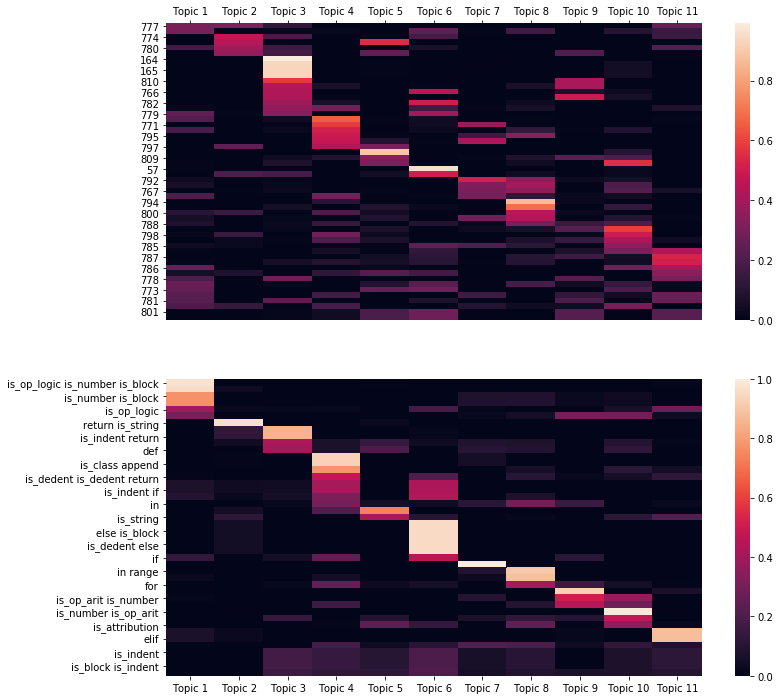

In [137]:
# Create a figure instance, and the two subplots
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
# fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(12,12))


sns.heatmap(document_topic_df, ax=ax1)
ax1.xaxis.tick_top()
sns.heatmap(word_topic_df, ax=ax2)

plt.show()

In [138]:
Counter(np.argmax(document_topic, axis=1))

Counter({8: 1, 1: 4, 5: 8, 2: 7, 3: 6, 7: 7, 0: 2, 10: 8, 9: 6, 6: 2, 4: 3})

In [96]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ", ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [97]:
print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = vectorizer.get_feature_names()
print_top_words(model, tfidf_feature_names, 26)


Topics in NMF model (Frobenius norm):
Topic #0: is_op_logic is_number, is_op_logic is_number is_block, is_number is_block, is_number is_block is_indent, is_number, is_op_logic, if, is_dedent is_dedent, is_indent if, is_block is_indent if, is_number is_op_arit, range, elif, is_dedent elif, is_dedent is_dedent return, is_block is_indent return, is_indent return, is_dedent return, is_op_arit is_number, in range, is_indent, is_dedent, is_block is_indent, else is_block is_indent, for, is_attribution
Topic #1: return is_string, is_string, is_indent return, is_block is_indent return, is_block is_indent if, is_indent if, return, is_dedent is_dedent, is_op_logic is_number, is_class, is_op_logic, is_op_arit is_number, elif, is_attribution, is_block is_indent, is_block, is_attribution is_list, def, in range, in, i, for, else is_block is_indent, else is_block, else, if
Topic #2: is_block is_indent return, is_indent return, return, def, is_indent, is_dedent, is_block is_indent, is_block, is_op_ari